# * TITTEL *

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.interpolate import RectBivariateSpline
from module.interpolate import Interpolator
import matplotlib.patches as mpatches

In [2]:
# Parameters for the model
# --------- Particle parameters ---------
particle_plot_parameters = {"alpha":1, "linewidth":0.9}

# --------- Grid parameters ---------
grid_streamplot_parameters = {"color": "grey","density": 0.5,"linewidth": 0.25,"arrowsize": 1,"arrowstyle": "->"}
grid_scatter_initial_parameters = {"s": 5, "c": "blue", "marker": "o", "label": "Initial position"}
grid_scatter_final_parameters = {"s": 5, "c": "red", "marker": "o", "label": "Final position"}
grid_plot_parameters = {"alpha":1, "linewidth":2}

# ----------- Map parameters ------------
# * Map projection
map_streamplot_parameters = {"color": "grey","density": 1,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
map_scatter_initial_parameters = {"s": 2.5, "color": "darkblue"}
map_scatter_final_parameters = {"s": 2.5, "color": "green"}
map_plot_parameters = {"alpha": 0.3, "linewidth": 0.1,"color":"cornflowerblue"}

# * XY projection
xy_streamplot_parameters = {"color": "grey","density": 1,"linewidth": 1,"arrowsize": 1,"arrowstyle": "->"}
xy_scatter_initial_parameters = {"s": 2.5, "color": "darkblue"}
xy_scatter_final_paramaeters = {"s": 2.5, "color": "green"}
xy_plot_parameters = {"alpha": 0.3, "linewidth": 0.1,"color":"cornflowerblue"}

# * Labels 
init_label = mpatches.Patch(color='darkblue', label='Initial position')
final_label = mpatches.Patch(color='green', label='Final position')
plot_label = mpatches.Patch(color='cornflowerblue', label='Trajectories')
stream_label = mpatches.Patch(color='grey', label='Velocity field')
stranded_label = mpatches.Patch(color='red', label='Stranded particles')

---

# Introduction

Plastic pollution in the ocean is a worldwide discussed topic because the consequences are disruptive for the environment, harming the ecosystem and posing a threat to marine life and human health. This settles why it is crucial to understand the dynamics of plastic particle transport in the ocean. By implementing the Langrangian particle method it is possible to predict where plastic particles will end up from their initial position in the ocean, which in turn will give us a better overview and a possiblity to initiate countermeasures. 

The Langrangian method consists of representing the plastic particles as numerical points and simulating the individual particles trajectories as they are traveling with the wind and current. The result is a simulation that calculates the probability of finding particles at specific locations at a given time. We do not need to model the fluid itself, as this information is produced and simulated by the Meteorological Institute [1]. Using this data, we access a more realistic understanding of the movement of the particles as well as accumulation zones.

---

## Simulation of single particle in analytical velocity field

Velocity field  is given by
$$ \dot{x}(t)= [{v_x}(\vec{x},t), {v_y}(\vec{x},t)]$$
$$ v_x = −\pi A \sin(\pi f(x,t)) \cos(\pi y) $$
$$ v_y = \pi A \cos(\pi f(x,t)) \sin(\pi y) \frac{\partial f(x,t)}{\partial x}$$
$$ f(x,t) = a(t)x^2 + b(t)x $$
$$ a(t) = \epsilon \sin(\omega t) $$ 
$$ b(t) = 1 −2 \epsilon \sin(\omega t)$$

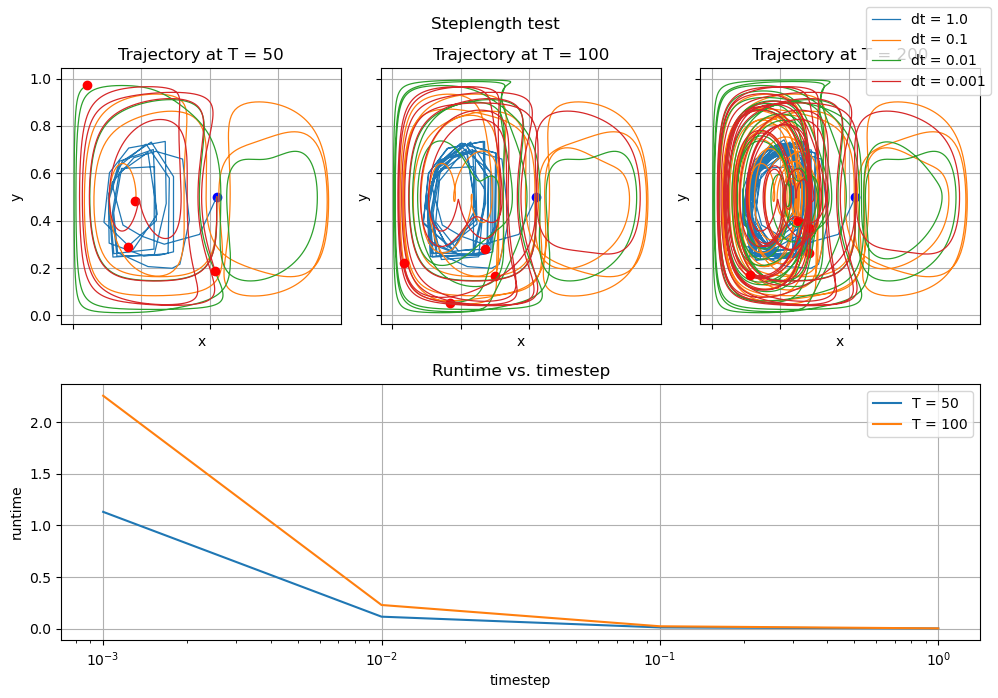

In [3]:
from module.interpolate import velocity
from module.utilities import run_steplength_test

X0 = np.array([[1.05], [0.50]]) # Initial position
time_testvalues = np.array([50, 100, 200]) # Test values
dt_testvalues = np.array([1, 0.1, 0.01, 0.001]) 
run_steplength_test(velocity, X0, time_testvalues=time_testvalues, stepsize_testvalues=dt_testvalues, **particle_plot_parameters) # Testing

For the first time interval $t \in [0, 50]$, the time-step $dt = 0.1$ seems to be suffiecient to represent the particle.
For the time interval $t \in [0, 100]$, $dt = 0.1$ deviates more from the shorter time steps, and is not short enough to represent the particle path correctly. With $dt = 0.01$ however, the approximation of the particle tracjectory is more accurate when comparing to the smaller timestep. 

Regarding the runtime, the biggest reduction happens when increasing $dt$ from 0.001 to 0.01. The graph shows a double in runtime when the time interval doubles, i.e. runtime is proportional to array length when using numpy arrays. For the time intervals tested here, the length of the arrays is not long enough for $dt$ to have a remarkable impact on runtime. For calculations going over several days, which will be the case later in the rapport, $dt$ will have to be considerably larger.

Due to the significant reduction in runtime, as well as the high accuracy of the trajectory, $dt = 0.01$ is the most economic timestep for these calculations.


### Simulation of multiple particles in a $0.1 \times 0.1$ grid

In [4]:
from module.trajectory import Trajectory

time_interval = [0, 10]
dt =  0.01
Np  = 100
mode = "grid"
gridsize = [-0.1, 0.1]

traj = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=gridsize)
traj(velocity)
traj.info()

Trajectory with:
Np: 100 particles
Time: [0, 10]
Time step: 0.01
Mode: grid
Check land: False
Velocity shape: (1000, 100)
X, Y shape: (100, 100)
U, V shape: (100, 100)
xmin: -1.3308532169979765, xmax: 1.119655549314349
ymin: -0.9981712094645157, ymax: 0.9981712094645157
Distance mean: 1.6726556791848577


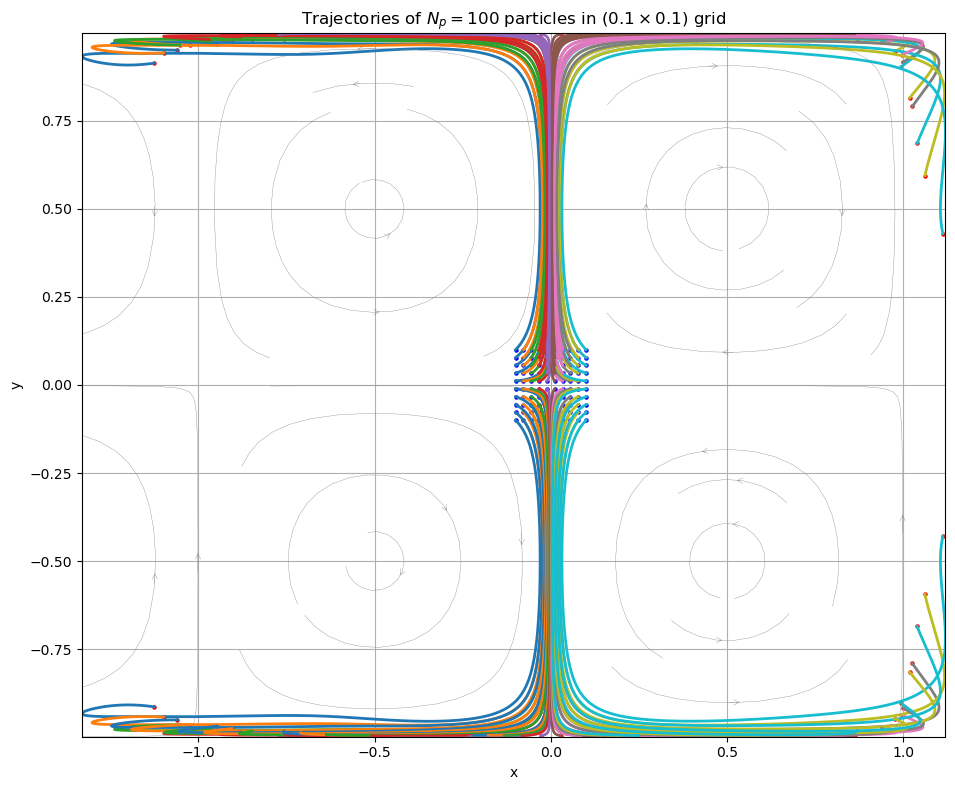

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

traj.plot(ax, **grid_plot_parameters)
traj.streamplot(ax, **grid_streamplot_parameters)
traj.scatter(ax, t=0, **grid_scatter_initial_parameters)
traj.scatter(ax, t=-1, **grid_scatter_final_parameters)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Trajectories of $N_p = 100$ particles in $(0.1\\times 0.1)$ grid")
plt.grid()
plt.tight_layout()

plt.show()

Depending on the initial position of each particle, here only separated by a distance of 0.01 units, takes different paths. The time interval is here limited to $t \in [0, 10]$ The streamlines represent the velocity field at $t=0$ to give an idea of the impact of the current and wind. This will change with time, but keeps somewhat the same shape. The particles on the further right are caught by the streams to the right, and similarly on the left side. 

In [6]:
streamplot_parameters = {"color": "grey","density": 1,"linewidth": 0.3,"arrowsize": 1,"arrowstyle": "->"}
scatter_initial_parameters = {"s": 5, "c": "blue", "marker": "o", "label": "Initial position"}
scatter_final_parameters = {"s": 5, "c": "red", "marker": "o", "label": "Final position"}
plot_parameters = {"alpha":1, "linewidth":2}


time_interval = [0, 10]
dt =  0.01
Np  = 100
mode = "grid"
gridsize = [-0.1, 0.1]
time_velocity_field = [0, 5, 10]

traj = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=gridsize)
traj(velocity)
traj.info()

Trajectory with:
Np: 100 particles
Time: [0, 10]
Time step: 0.01
Mode: grid
Check land: False
Velocity shape: (1000, 100)
X, Y shape: (100, 100)
U, V shape: (100, 100)
xmin: -1.3308532169979765, xmax: 1.119655549314349
ymin: -0.9981712094645157, ymax: 0.9981712094645157
Distance mean: 1.6726556791848577


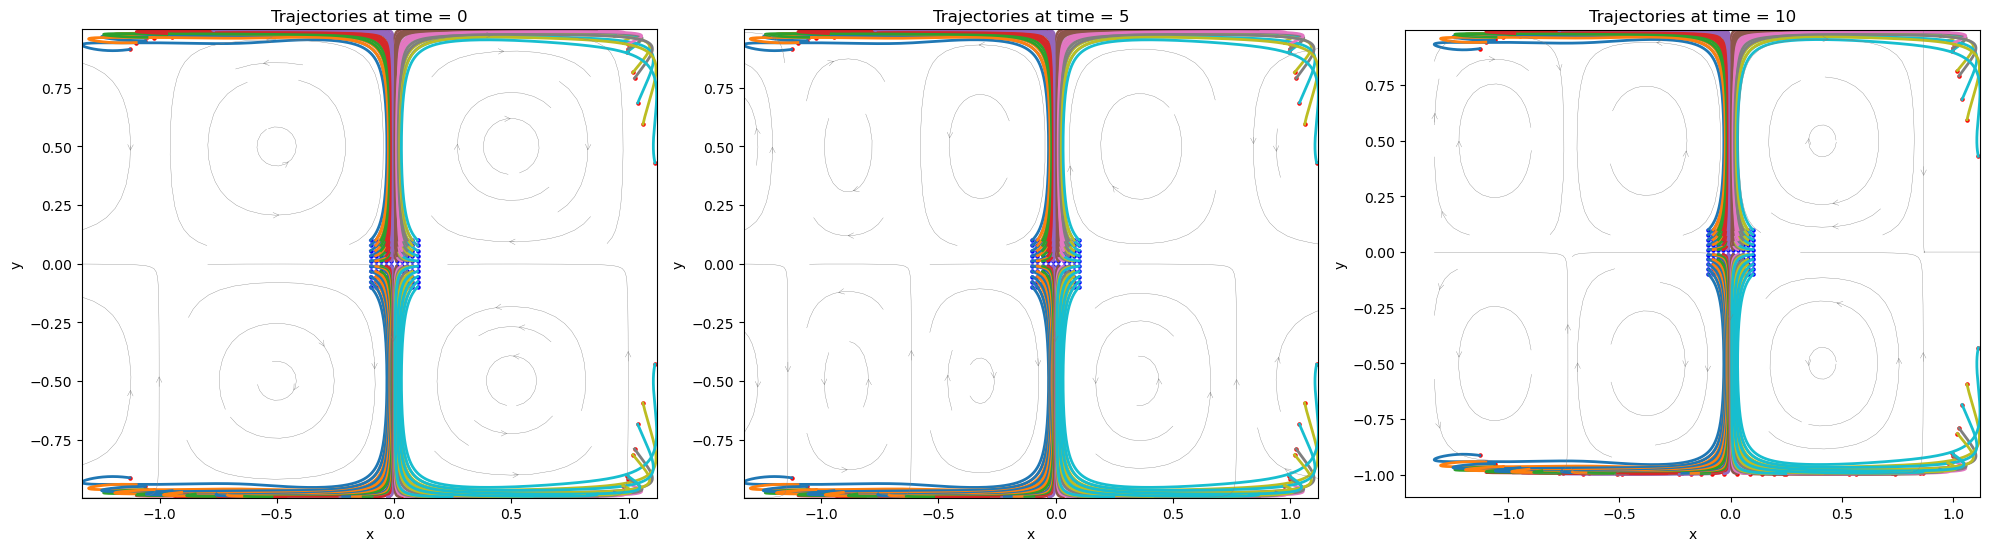

In [7]:

fig, ax = plt.subplots(1, 3, figsize=(20, 12))

for i, time in enumerate(time_velocity_field):
    traj.plot(ax[i], **grid_plot_parameters)
    traj.streamplot(ax[i],time_velocity_field = time, **grid_streamplot_parameters)
    traj.scatter(ax[i], t=0, **grid_scatter_initial_parameters)
    traj.scatter(ax[i], t=-1, **grid_scatter_final_parameters)
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].set_title(f"Trajectories at time = {time}")

plt.tight_layout()
plt.show()

Depending on the time, here plotted at $t = 0$, $t=5$ and $t=10$, the velocity field changes some, but the overall shape remains quite similar.

### Correlation between number of particles and runtime

<Figure size 750x500 with 0 Axes>

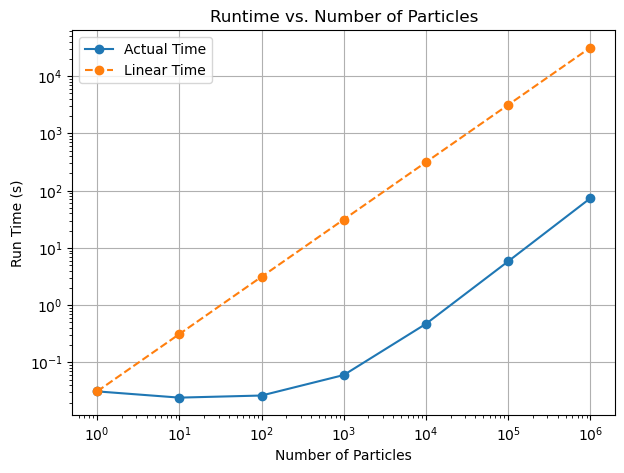

In [8]:
from module.utilities import run_timing_test

dt = 0.01
time_interval = [0, 10]
Np_testvalues = [1, 10, 100, 1000, 10_000, 100_000, 1_000_000]

times, linear_times = run_timing_test(interpolator=velocity, number_of_particles_testvalues = Np_testvalues, time_interval = time_interval, stepsize=0.01)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(Np_testvalues, times, marker="o", label="Actual Time")
ax.plot(Np_testvalues, linear_times, marker="o", linestyle="--", label="Linear Time")
ax.set_title("Runtime vs. Number of Particles")
ax.set_xlabel("Number of Particles")
ax.set_ylabel("Run Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.grid(True)
plt.show()

The graph shows the curve is approximately constant for fewer particles, i.e. shorter arrays. When the number of particles reach approximately 1000, the run time takes on a linear increase.

For few particles, the linear increase may be too little to measure. The overhead time, in this case, is the time that python and jupyter cell/kernel uses as preparation for executing the task at hand. This overhead time can be few milliseconds, meaning if the running time of the numerical calculations are much smaller than the overhead time, there are no noticable variations between runtimes before it reaches a certain threshold. Here, this threshold seems to be reached when there are over 100 particles.

Another possible explanation for the constant runtime is how numpy allocates memory. For smaller array-sizes the compiler may overestimate how much memory needs to be allocated to avoid asking for new memory for every inceased index. Adding elements threrfore doesn't require additional runtime, resulting in constant time $\mathcal{O}(1)$. For bigger array-sizes, Python needs to allocate memory more frequently, resulting in a linear increase of runtime $\mathcal{O}(n)$.


---


## Simulation of plastic particles using wind and current data
### Plastic particles in Trondheimsfjorden

In [9]:
Np = 1000
days, dt = 5, 3600
T = [0, days * 24 * dt]
mode = "map"
loc, scale = [790_000, 490_000], 10_000

dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

traj_xy = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode=mode, location=loc, scale=scale)
traj_xy(interpolator)
traj_xy.info()

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 752635.1980477462, xmax: 958798.9911797096
ymin: 422717.0885704659, ymax: 523280.50452816306
Distance mean: 178848.32445606648
Windage factor: 0.03


### Simulation projected on to the $xy$-plane

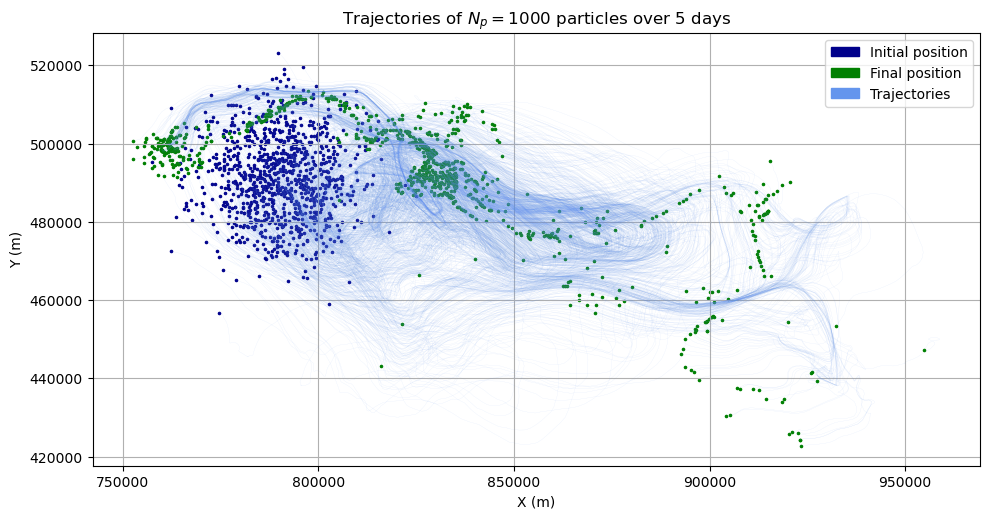

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
traj_xy.plot(ax, **map_plot_parameters)
traj_xy.scatter(ax, t=0, label="Initial position", **map_scatter_initial_parameters)
traj_xy.scatter(ax, t=-1, label="Final position", **map_scatter_final_parameters)
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend(handles=[init_label, final_label, plot_label])
ax.grid()

plt.tight_layout()
plt.show()



Since the implementation of the numerical integrater *"Heun's method"* is quite fast, the number of particles can be in the range $N_p \in (0, 10000]$. For example, at $N_{(p, max)} = 10.000$, the run time is approximately one minute. 

Location and initial conditions are set at $t_0 = 0$ following a Gaussian distribution, within the $x$ and $y$ grid from the dataset. This grid represents the planar projection of Norway, including the shoreline.

In this example the location corresponds to the coast outside Trondheim.
$$(x_0, y_0) \backsim \mathcal{N}(\mu = (790000, 490000), \sigma = 10000)$$

In the five days showed in the plot, the trajectory lines show many of the particles taking a curved path as a result of the wind and current. For example at grid coordinate $(875000, 480000)$ the particles are most likely caught by a strong current, shifting their direction approximatly $180\degree $. 

### Simulation projected on world map

In [11]:
traj_map = Trajectory(time_interval=T, number_of_particles=Np, stepsize=dt, mode="map", location=loc, scale=scale)
traj_map(interpolator)
traj_map.info()

Trajectory with:
Np: 1000 particles
Time: [0, 432000]
Time step: 3600
Mode: map
Check land: False
Velocity shape: (120, 1000)
X, Y shape: (120, 1000)
U, V shape: (120, 1000)
xmin: 752230.7475739433, xmax: 971577.2484767819
ymin: 423325.77545425657, ymax: 521663.9588032724
Distance mean: 178935.73605707733
Windage factor: 0.03


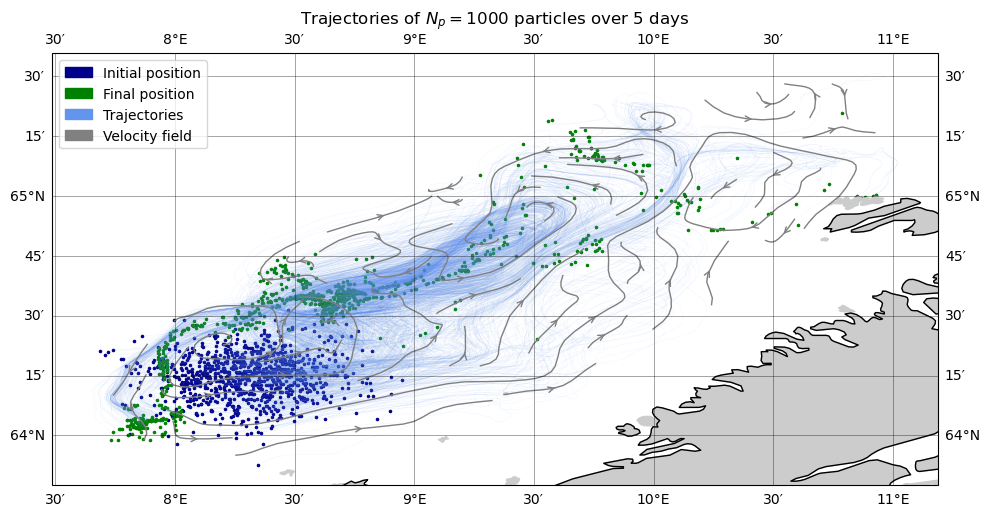

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,7), subplot_kw={"projection": ccrs.PlateCarree()})
traj_map.init_map(ax, **map_plot_parameters)
traj_map.scatter(ax, t=0, label="initial position", **map_scatter_initial_parameters)
traj_map.scatter(ax, t=-1, label="final position", **map_scatter_final_parameters)
traj_map.streamplot(ax, **map_streamplot_parameters)
ax.legend(handles=[init_label, final_label, plot_label, stream_label])
ax.set_title(f"Trajectories of $N_p = {Np}$ particles over {days} days")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.grid()
plt.tight_layout()
plt.show()

The world map shows the same particle trajectory as the plot in the xy-plane above, where the turning point $(875000, 480000)$ here corresponds roughly to a latitude of $64.8 \degree N $ and a longitude of $9.4 \degree E$. This plot also illustrates the streamlines of the current and wind creating a vortex shape in this location, explaining the particles' sudden shift in direction.

### Comparison of different initial conditions

In [13]:
Np=500
days = 5
time_interval = [0, days * 24 * 3600]
dt=3600
mode = "map"
dataset = xr.open_dataset("data/NorKyst-800m.nc")
interpolator = Interpolator(dataset=dataset)

bergen, scale = [250000, 460000], 10000
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=bergen, scale=scale)
traj_bergen(interpolator)
# traj_bergen.info()

lofoten, scale = [1240000, 480000], 10000
traj_lofoten = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=lofoten, scale=scale)
traj_lofoten(interpolator)
# traj_lofoten.info()

oslo, scale = [190_000, 100_000], 5000
traj_oslo = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=oslo, scale=scale)
traj_oslo(interpolator);
# traj_oslo.info()


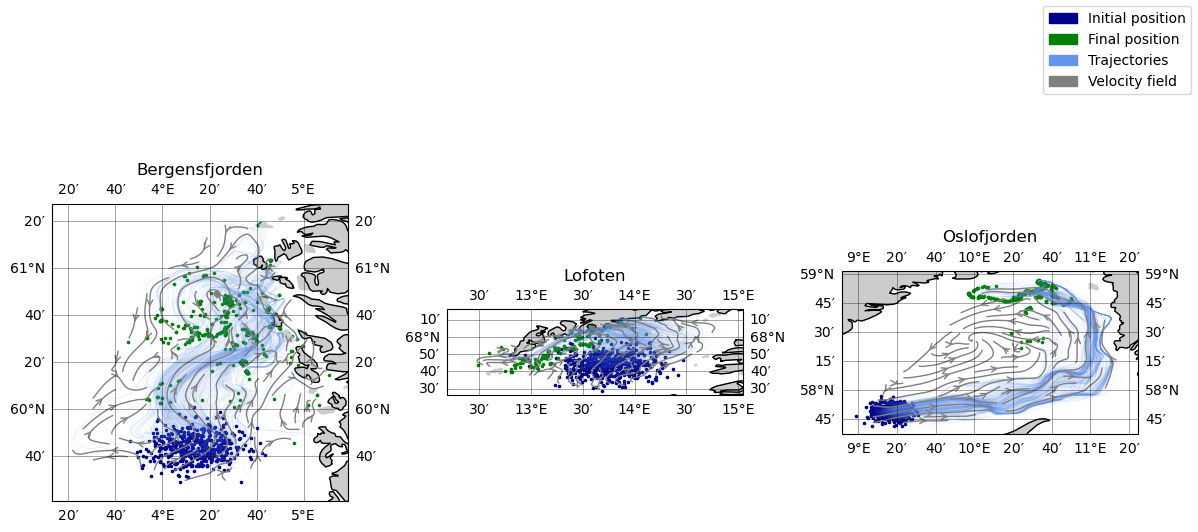

In [14]:
fig, ax = plt.subplots(1,3,figsize=(12, 7), subplot_kw={"projection": ccrs.PlateCarree()})

# Bergensfjorden
traj_bergen.init_map(ax[0], **map_plot_parameters)
traj_bergen.streamplot(ax[0], **map_streamplot_parameters)
traj_bergen.scatter(ax[0], t=0, **map_scatter_initial_parameters)
traj_bergen.scatter(ax[0], t=-1, **map_scatter_final_parameters)
ax[0].set_title("Bergensfjorden")


# Lofoten 
traj_lofoten.init_map(ax[1], **map_plot_parameters)
traj_lofoten.streamplot(ax[1], **map_streamplot_parameters)
traj_lofoten.scatter(ax[1], t=0, **map_scatter_initial_parameters)
traj_lofoten.scatter(ax[1], t=-1, **map_scatter_final_parameters)
ax[1].set_title("Lofoten")

# Oslofjorden
traj_oslo.init_map(ax[2], **map_plot_parameters)
traj_oslo.streamplot(ax[2], **map_streamplot_parameters)
traj_oslo.scatter(ax[2], t=0, **map_scatter_initial_parameters)
traj_oslo.scatter(ax[2], t=-1, **map_scatter_final_parameters)
ax[2].set_title("Oslofjorden")

fig.legend(handles=[init_label, final_label, plot_label, stream_label])
plt.tight_layout()
plt.show()

The plots show three simulations of $N_p = 500$ particle trajectories, in Bergensfjorden, outside Lofoten, and in Oslofjorden. The areas seem to have different path trends. Outside Bergensfjorden the wind and current is directed in various directions, resulting in a larger spread in the trajectories and final positions. The particles are first dragged in towards the shore, before being pulled out again.

The currents outside Lofoten seems to pull the particles out from the shore, resulting in a accumulation by the shoreline. The silulation does not take into account 

The particles in Oslofjorden follow a very homogenous curved path, where they end up along a continuous line.

---


## Simulation of particles reaching land



In [15]:
Np=500
days = 3
dt=3600
time_interval = [0, days * 24 * dt]
mode = "map"
loc, scale = [250_000, 460_000], 10000
time_array = np.arange(0, time_interval[1]-dt, dt)

interpolator = Interpolator(dataset=dataset)
traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
traj_bergen(interpolator)
traj_bergen.info()
stranded_percent = traj_bergen.get_land_percent()

Trajectory with:
Np: 500 particles
Time: [0, 259200]
Time step: 3600
Mode: map
Check land: True
Velocity shape: (72, 500)
X, Y shape: (72, 500)
U, V shape: (72, 500)
xmin: 219042.6600254379, xmax: 408973.07236858
ymin: 421187.31130107696, ymax: 513564.78428481024
Distance mean: 126757.89528924266
Land percent: 16.400000000000002%
Land particles: 72
Windage factor: 0.03


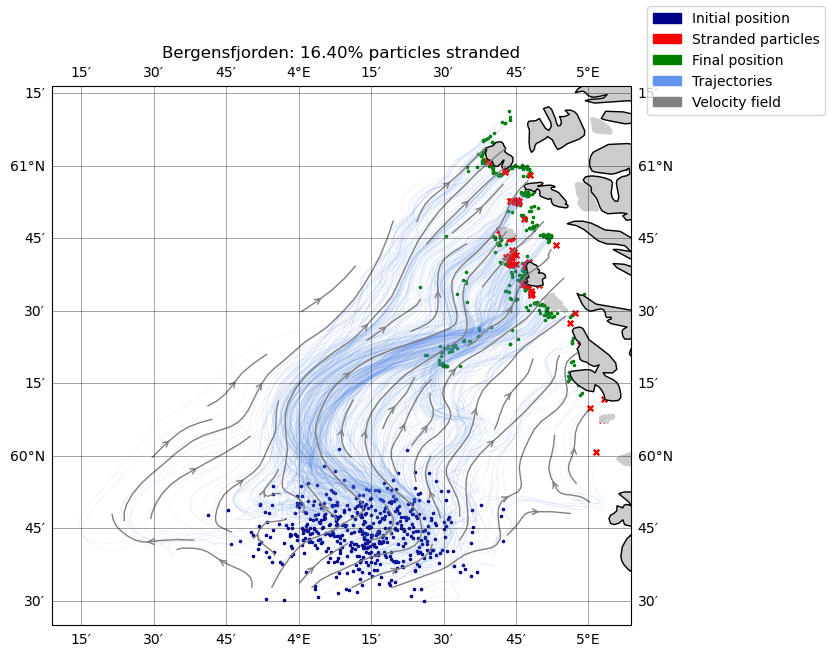

In [16]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw={"projection": ccrs.PlateCarree()})
traj_bergen.init_map(ax, **map_plot_parameters)
traj_bergen.plot(ax, **map_plot_parameters)
traj_bergen.scatter(ax, t=0, **map_scatter_initial_parameters)
traj_bergen.scatter(ax, t=-1, **map_scatter_final_parameters)
traj_bergen.streamplot(ax, **map_streamplot_parameters)
fig.legend(handles=[init_label, stranded_label, final_label, plot_label, stream_label])
plt.title(f"Bergensfjorden: {stranded_percent[-1]:.2f}% particles stranded")
plt.show()

The red points indicate where particles have reached land. Without this feature, as shown earlier of Bergensfjorden, the particles seem to move out from land. This plot shows they stop at shore, instead of being caught by the outward stream.

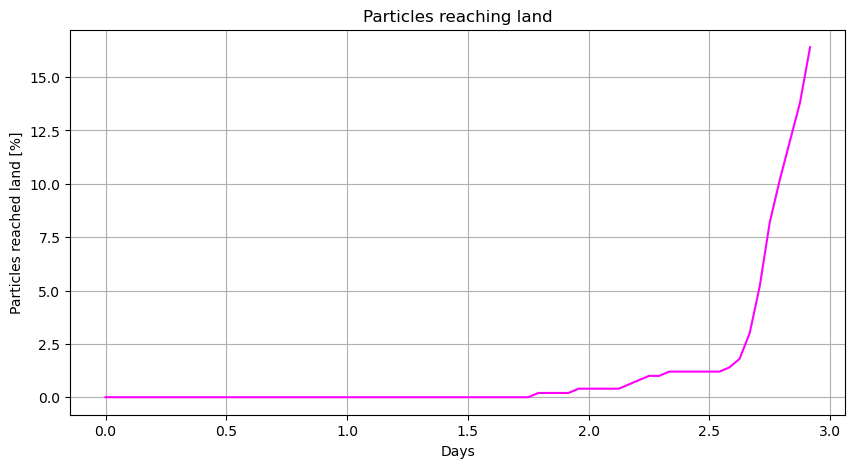

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_array/(3600*24), stranded_percent, color="magenta")
ax.set_title('Particles reaching land')
ax.set_xlabel('Days')
ax.set_ylabel('Particles reached land [%]')
ax.grid()
plt.show()

In this example the initial conditions were placed on the west coast, where the wind and ocean current-vectors are pointing towards the shore. As expected the amount of particles reaching land therefore increases with time. After three days, about 20% of the particles have reached shore. One can see from the map that there is not a 100 % correlation between the map and the data, displaying some particles on land even though they still seem to be in the water. Since the minimum depth of the data is set to 5 m, it is not certain the particle has reached land. There might be some error due to this approximation, but due to uncertainties such as the time-varying tide and the precision of the coastline, setting the on-land-limit to 5 m is seemingly a valid estimation.

### Particle sensitivity to windage factor $f_w$

The windage factor is a measure of how much the wind affects the particles' trajectory. The higher the windage factor, the more the particles are affected by the wind. In a practical sense, the windage factor capsulates the density of the plastic object. If the object has high density, it will be more submerged in water. The particle will therefore not be as affected by wind, resulting in a low windage factor.

$$ f_w \propto \frac{1}{\rho_{plastic}}

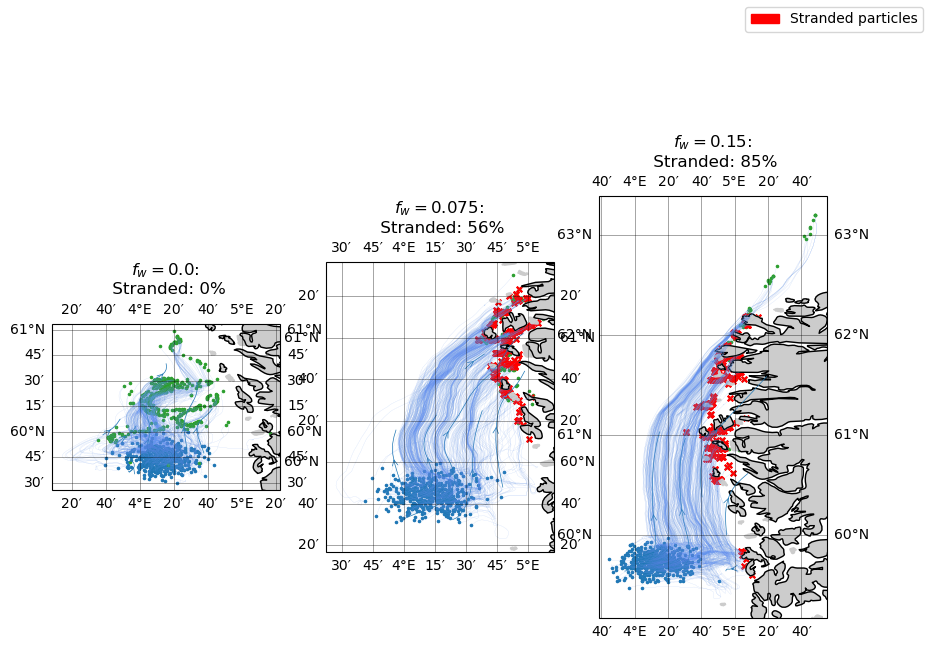

In [18]:
fw = np.linspace(0, 0.15, 5)
dataset = xr.open_dataset("data/NorKyst-800m.nc")
map_streamplot_parameters = {"density": 0.35, "linewidth": 0.5,"arrowsize": 1,"arrowstyle": "->"}
map_plot_parameters['alpha'] = 0.3

landed_percent = []
fig, ax = plt.subplots(1,3,figsize=(10,8),subplot_kw={"projection": ccrs.PlateCarree()})
c = 0

for w in fw:
    interpolator = Interpolator(dataset=dataset, fw=w)
    traj_bergen = Trajectory(time_interval=time_interval, stepsize=dt, number_of_particles=Np, mode=mode, location=loc, scale=scale, check_land=True)
    traj_bergen(interpolator)
    percent = traj_bergen.get_land_percent()
    landed_percent.append(percent)
    if w == 0 or w == 0.075 or w == 0.15:
        ax[c] = traj_bergen.init_map(ax[c], **map_plot_parameters)
        ax[c] = traj_bergen.streamplot(ax[c], **map_streamplot_parameters)
        traj_bergen.plot(ax[c], **map_plot_parameters)
        ax[c] = traj_bergen.scatter(ax[c], t=0, **{"label": "Initial Position","s":2.5})
        ax[c] = traj_bergen.scatter(ax[c], t=-1, **{"label": "Final Position", "s":2.5})
        ax[c].set_title(f"$f_w = {w}$: \n Stranded: {percent[-1]:.0f}%")
        c+=1
    

fig.legend(handles=[stranded_label])
plt.show()

The plots show particle movement for windage factors $f_w = 0$, $f_w = 0.075$, and $f_w = 0.15$, indicating a gradual descending object density. With zero windage factor, the object is completely submerged in water, and the trajectory is therefore only affected by the current. The plot shows that no particles reach land in these conditions, while a high windage factors drags almost all particles to land. For higher windage factors, all particles take on a more laminar, coherent path, contrary to the more turbulent trajectories for low wind-contribution. In this case, we can conclude despite a relatively small increase in windage factor, it drastically affects the route of the particles. 

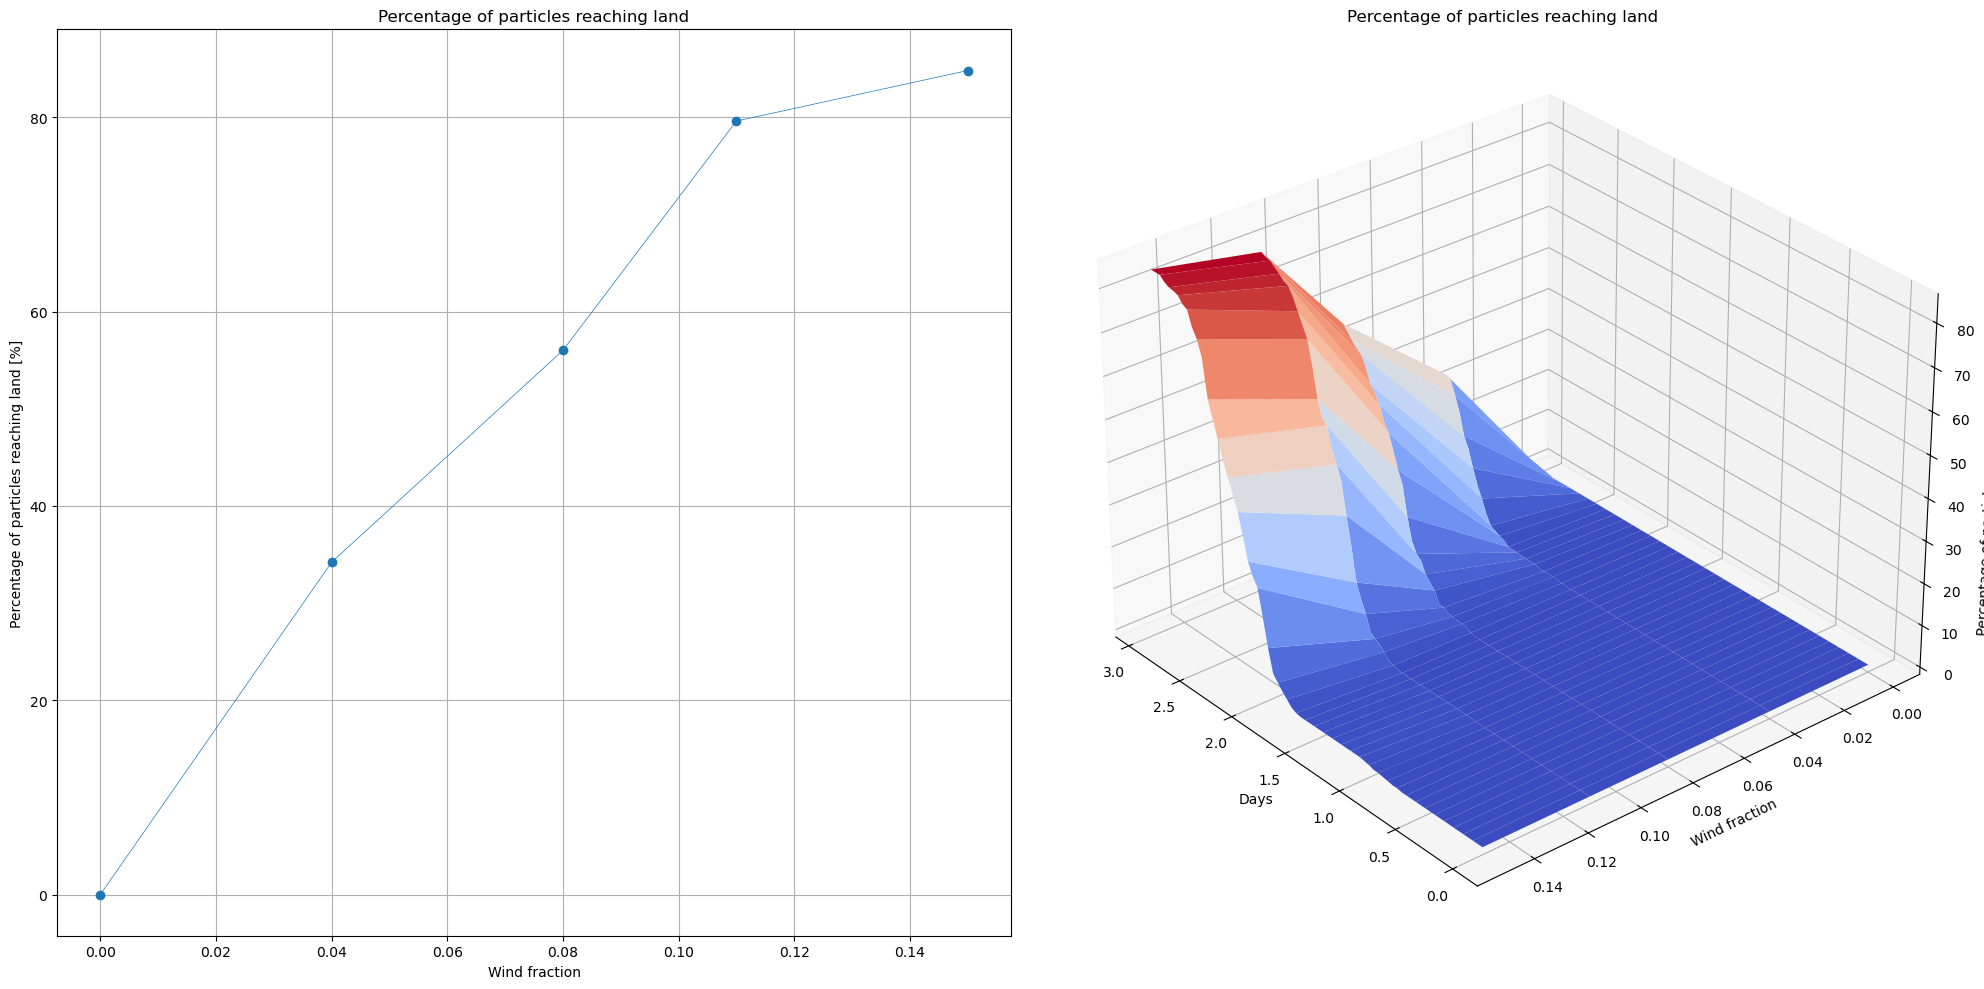

In [19]:
windage_factor = np.round(fw, 2)
landed_percent = np.array(landed_percent)
time_array = np.arange(0, time_interval[1] - dt, dt) / (3600 * 24)
X, Y = np.meshgrid(time_array, windage_factor)
Z = landed_percent

fig = plt.figure(figsize=(20, 10))

# 3D plot of % stranded over time at different windage factor
ax3d = fig.add_subplot(1, 2, 2, projection="3d")
ax3d.plot_surface(X, Y, Z, cmap="coolwarm")
ax3d.set_title("Percentage of particles reaching land")
ax3d.set_xlabel("Days")
ax3d.set_ylabel("Wind fraction")
ax3d.set_zlabel("Percentage of particles reaching land [%]")
ax3d.view_init(30, 140)

# % stranded at final time at different windage factor
ax = fig.add_subplot(1, 2, 1)
ax.plot(windage_factor, landed_percent[:, -1], marker="o", linewidth=0.5)
ax.set_title("Percentage of particles reaching land")
ax.set_xlabel("Wind fraction")
ax.set_ylabel("Percentage of particles reaching land [%]")
ax.grid()
plt.tight_layout()
plt.show()

The plot shows the percentage of particles reaching land up after three days, for different windage factors. The plot to the right includes the time dimention as well, with increasing amount of particles reaching land as time goes by. The plot shows that the amount of particles reaching land increases with time, and that the windage factor has a significant impact on the amount of particles reaching land.

---

## Conclusion

The simulation of plastic particle dynamics using Heuns numerical integration method gives valueable insight into the movement and accumulation of plastic in marine environments. Simulating trajectories of individual particles influenced by wind and current allows us to predict deposition areas of marine debris, either on land or at sea. The results shows windage factor has a significant impact on the particle path, which in turn is determined by the density of the plastic. In reality, the debris has a non-uniform distribution of densities, resulting in each individual particle may take on distinct paths despite having the same initial position. In our simulation, all particles have been generalized to have the same, constant windage factor, disregarding this variation. 

Numerical particle simulations, albeit rather simplified, can contribute in clean-up operations. This is done by detecting where waste accumulates, found when decomposition areas and wind and current data is known. 
Further improvement of this model includes implementing additional variables to describe the particles, such as a distribution of density and a time-dependent degradation factor. By this, we increase our knowledge and capability to mitigate the environmental impact of plastic pollution in the ocean.


---

## References
[1]: Meteorologisk Institutt. Retrieved 3. April 2024. NorKyst Data. https://thredds.met.no/thredds/catalog/fou-hi/norkyst800m-1h/catalog.html

---